# Reducing the energy spread in our X-band linac from 100 MeV to 500 GeV

In [1]:
import RF_Track as RFT
import numpy as np
import scipy
import matplotlib.pyplot as plt

## Load the lattice from appropriate scripts

In [2]:
import scripts

## Let's define some key parameters
We use a structure to collect all relevant parameters

In [3]:
# Structure "setup"
class Setup:
    def __init__(self):
        self.Q = -1 # single-particle charge, in units of e
        self.mass = RFT.electronmass # MeV/c^2
        self.population = RFT.nC # 50 * RFT.pC; % number of real particles per bunch
        
        self.sigma_t = 0.100 # mm/c
        self.sigma_pt = 0.1 # permille, momentum spread

        self.P_i = 100 # initial momentum, MeV/c
        self.P_f = 500 # final momentum, MeV/c

        self.phid = 0 # deg, phase of the RF structures
        self.mu = 90 # deg, FODO phase advance per cell

## Let's build the linac lattice
We use a standard FODO lattice, with four structures every two consecutive quadrupoles and 90 degrees phase advance per cell

In [4]:
setup = Setup()
rf_name = 'data/TWS_Xband.dat'
LINAC = scripts.init_linac_lattice (rf_name, setup)

In [5]:
LINAC.size()

7

In [6]:
LINAC.get_length()

7.632659196799999

## Let's define and track the reference particle

In [7]:
P0 = scripts.init_reference_particle (setup)

# Track the reference particle
P1 = LINAC.track(P0)

In [8]:
P1.get_phase_space()

array([[   0.        ,    0.        ,    0.        ,    0.        ,
        7632.6800656 ,  477.31926446]])

## ...and a bunch

In [9]:
B0 = scripts.init_bunch(rf_name, setup)

## Perform tracking

In [10]:
B1 = LINAC.track(B0)

Let's make some plots...

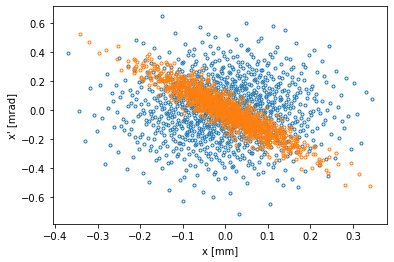

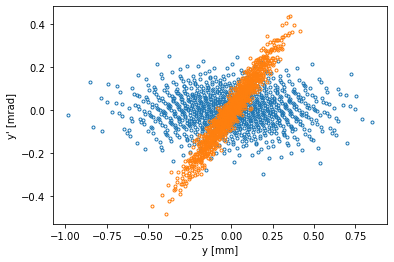

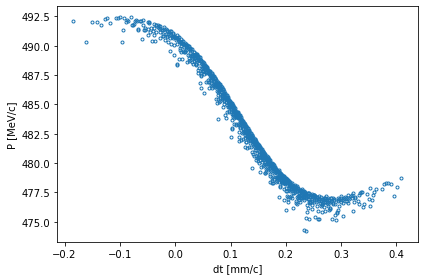

In [11]:
M0 = B0.get_phase_space ('%x %xp %y %yp %dt %P')
M1 = B1.get_phase_space ('%x %xp %y %yp %dt %P')

plt.figure()
plt.plot(M0[:,0], M0[:,1], '.', label='Initial', mfc='none')
plt.plot(M1[:,0], M1[:,1], '.', label='Final', mfc='none')
plt.xlabel('x [mm]')
plt.ylabel("x' [mrad]")

plt.figure()
plt.plot(M0[:,2], M0[:,3], '.', label='Initial', mfc='none')
plt.plot(M1[:,2], M1[:,3], '.', label='Final', mfc='none')
plt.xlabel('y [mm]')
plt.ylabel("y' [mrad]")

plt.figure()
plt.plot(M1[:,4], M1[:,5], '.', label='Final', mfc='none')
plt.xlabel('dt [mm/c]')
plt.ylabel('P [MeV/c]')
plt.tight_layout()

Text(0, 0.5, 'position [mm]')

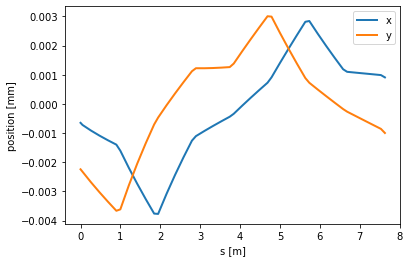

In [12]:
T = LINAC.get_transport_table('%S %mean_x %mean_y')

plt.plot(T[:,0], T[:,1], linewidth=2, label='x')
plt.plot(T[:,0], T[:,2], linewidth=2, label='y')
plt.legend()
plt.xlabel('s [m]')
plt.ylabel('position [mm]')

Text(0, 0.5, '$\\epsilon_n$ [mm.mrad]')

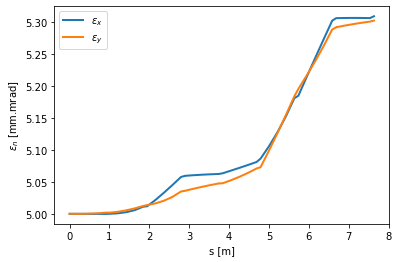

In [13]:
T = LINAC.get_transport_table('%S %emitt_x %emitt_y')

plt.plot(T[:,0], T[:,1], linewidth=2, label=r'$\epsilon_x$')
plt.plot(T[:,0], T[:,2], linewidth=2, label=r'$\epsilon_y$')
plt.legend()
plt.xlabel('s [m]')
plt.ylabel(r'$\epsilon_n$ [mm.mrad]')

## Let's reduce the energy spread

Perform a 1D optimisation of the phase

In [14]:
def merit(LINAC, B0, phid):  
    # set the phase of all structures
    for rf in LINAC.get_rf_elements():
        rf.set_phid(phid)   
    # perform tracking
    B1 = LINAC.track(B0)
    I1 = B1.get_info()
    M = I1.sigma_pt
    # display some numbers...
    print(phid, M)
    return M
    
phid_min = scipy.optimize.fminbound(lambda x: merit(LINAC, B0, x), -30, 30)

-7.082039324993694 7.856281335481044
7.082039324993687 12.503638027130203
-15.835921350012619 5.38692505304307
-21.246117974981072 4.178005671378766
-24.589803375031543 3.68617440815857
-26.656314599949525 3.5332125043891547
-28.363185376813533 3.512289046074878
-27.884221816726548 3.5080534089236957
-27.866406939768897 3.508049384648867
-27.868803208365915 3.5080492866149866
-27.86878719451695 3.5080492865961377
-27.868761918249604 3.508049286602263
-27.868777539841933 3.5080492866358326
-27.8687909412112 3.508049286594211
-27.868795626847355 3.5080492866100603


Update the linac lattice to use the new phase

In [15]:
setup.phid = phid_min

LINAC_1 = scripts.init_linac_lattice(rf_name, setup) #recreate the linac

In [16]:
B1_corrected = LINAC_1.track(B0)

Text(0, 0.5, '$\\epsilon_n$ [mm.mrad]')

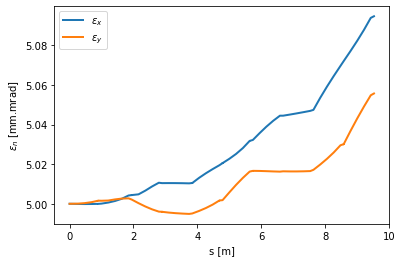

In [17]:
T = LINAC_1.get_transport_table('%S %emitt_x %emitt_y');


plt.plot(T[:,0], T[:,1], linewidth=2, label=r'$\epsilon_x$')
plt.plot(T[:,0], T[:,2], linewidth=2, label=r'$\epsilon_y$')
plt.legend()
plt.xlabel('s [m]')
plt.ylabel(r'$\epsilon_n$ [mm.mrad]')

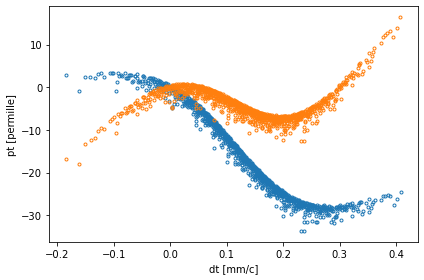

In [18]:
M1_uncorrected = B1.get_phase_space ('%x %xp %y %yp %dt %pt');
M1_corrected = B1_corrected.get_phase_space ('%x %xp %y %yp %dt %pt');

plt.figure()
plt.plot(M1_uncorrected[:,4], M1_uncorrected[:,5], '.', label='uncorrected', mfc='none')
plt.plot(M1_corrected[:,4], M1_corrected[:,5], '.', label='corrected', mfc='none')
plt.xlabel('dt [mm/c]')
plt.ylabel('pt [permille]')
plt.tight_layout()